# Alertness‑Score Pipeline v2 – ICA, Rich Features & Model Zoo
**Objective**: derive a robust 0‑100 alertness score suitable for real‑time cue control.

Upgrades from v1:
* **ICA** (per‑recording) to scrub ocular artefacts before feature extraction.
* Extra features – Hjorth parameters, spectral entropy, band ratios.
* **Signal‑quality gate** keeps noisy epochs out everywhere (training + viz).
* Model zoo: Logistic Reg, HistGB, RandomForest, LightGBM (if available).
* CV AUC comparison + per‑stage boxplots + per‑sample timeline plot.


In [1]:

import os, pickle, warnings, math
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from scipy.signal import butter, filtfilt, welch
from scipy.stats import entropy as scipy_entropy
import mne
from mne.preprocessing import ICA, create_eog_epochs

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False

sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


In [2]:

DATA_ROOT = Path('sample_data')
FS = 125               # Hz
EPOCH_SEC = 30
MIN_GOOD_RATIO = 0.6
TRAIN_POS, TRAIN_NEG = 'Wake', 'Deep'
BANDS = {'delta':(0.5,4),'theta':(4,8),'alpha':(8,12),'beta':(12,30),'gamma':(30,45)}


In [3]:

def bandpass(sig, fs=FS, low=0.5, high=45, order=4):
    b,a = butter(order, [low/(0.5*fs), high/(0.5*fs)], btype='band')
    return filtfilt(b,a,sig, axis=-1)

def run_ica(raw):
    """Remove EOG artefacts via ICA; returns cleaned Raw"""
    ica = ICA(n_components=min(15, len(raw.ch_names)), random_state=97, max_iter='auto')
    ica.fit(raw)
    try:
        eog_epochs = create_eog_epochs(raw, reject_by_annotation=True)
        eog_inds, scores = ica.find_bads_eog(eog_epochs)
        ica.exclude = eog_inds
    except Exception:
        pass
    return ica.apply(raw.copy())

def hjorth_params(sig):
    activity = np.var(sig)
    diff = np.diff(sig)
    mobility = math.sqrt(np.var(diff)/activity) if activity else 0
    diff2 = np.diff(diff)
    complexity = math.sqrt(np.var(diff2)/np.var(diff)) if np.var(diff) else 0
    return activity, mobility, complexity

def spectral_entropy(sig, fs=FS, nperseg=FS*2):
    f, Pxx = welch(sig, fs=fs, nperseg=nperseg)
    Pxx_norm = Pxx / np.sum(Pxx)
    return scipy_entropy(Pxx_norm, base=2)

def epoch_features(epoch, fs=FS):
    feats = {}
    for ch in range(epoch.shape[0]):
        sig = epoch[ch]
        feats[f'ch{ch}_mean'] = sig.mean()
        feats[f'ch{ch}_std']  = sig.std()
        a, mob, com = hjorth_params(sig)
        feats[f'ch{ch}_activity']   = a
        feats[f'ch{ch}_mobility']   = mob
        feats[f'ch{ch}_complexity'] = com
        feats[f'ch{ch}_spec_entropy'] = spectral_entropy(sig, fs)
        f, P = welch(sig, fs=fs, nperseg=4*fs)
        total = np.trapz(P, f)
        for band, (lo, hi) in BANDS.items():
            mask = (f>=lo)&(f<hi)
            power = np.trapz(P[mask], f[mask])
            feats[f'ch{ch}_{band}_abs'] = power
            feats[f'ch{ch}_{band}_rel'] = power/total if total else 0
    # Channel‑0 ratio
    feats['theta_alpha_ratio'] = (
        feats.get('ch0_theta_abs', 0) / feats.get('ch0_alpha_abs', 1)
        if feats.get('ch0_alpha_abs', 0) else 0
    )
    return feats


In [4]:

def build_epochs(rec_dir: Path):
    edf = next(rec_dir.glob('*.edf'))
    stage_csv = next(rec_dir.glob('*[0-9].csv'))
    sqc_csv   = next(rec_dir.glob('*SQC.csv'))
    raw = mne.io.read_raw_edf(edf, preload=True, verbose=False)
    raw.filter(0.5, 45, fir_design='firwin', verbose=False)
    raw_clean = run_ica(raw)
    data = raw_clean.get_data()[:4]
    data = bandpass(data)
    df_stage = pd.read_csv(stage_csv)
    df_sqc = pd.read_csv(sqc_csv)
    start_ts = df_stage['Timestamp'].min()
    rows = []
    for _, row in df_stage.iterrows():
        ts = row['Timestamp']; lbl = row['Sleep stage']
        st = int((ts - start_ts)*FS); en = st + EPOCH_SEC*FS
        if en > data.shape[1]: break
        mask = (df_sqc['Timestamp']>=ts)&(df_sqc['Timestamp']<ts+EPOCH_SEC)
        good_ratio = (df_sqc.loc[mask,'Signal quality']=='Good').mean()
        if good_ratio < MIN_GOOD_RATIO: continue
        ep = data[:, st:en]
        feats = epoch_features(ep)
        feats.update({'good_ratio': good_ratio, 'stage': lbl, 'record': rec_dir.name})
        rows.append(feats)
    return pd.DataFrame(rows)


In [5]:

rec_dirs = [p for p in DATA_ROOT.iterdir() if p.is_dir()]
if not rec_dirs:
    raise FileNotFoundError('sample_data directory missing or empty.')
epochs_df = pd.concat([build_epochs(p) for p in rec_dirs], ignore_index=True)
print('Epochs shape:', epochs_df.shape)


Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 4.5s.
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 0 ICA components
    Projecting back using 4 PCA components
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 3.9s.
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 0 ICA components
    Projecting back using 4 PCA components
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 4.5s.
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 0 ICA components
    Projecting back using 4 PCA components
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 6.7s.
Ap

In [6]:

train_df = epochs_df[epochs_df['stage'].isin([TRAIN_POS, TRAIN_NEG])].copy()
train_df['y'] = (train_df['stage'] == TRAIN_POS).astype(int)
X = train_df.drop(columns=['stage','record','y'])
y = train_df['y']
groups = train_df['record']
gkf = GroupKFold(n_splits=5)


In [7]:

models = {
    'LogReg': LogisticRegression(max_iter=1500),
    'HistGB': HistGradientBoostingClassifier(),
    'RF': RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight='balanced')
}
if LIGHTGBM_AVAILABLE:
    models['LGBM'] = LGBMClassifier(objective='binary', n_estimators=400)
results = {}
for name, clf in models.items():
    steps = [('imp', SimpleImputer(strategy='median'))]
    if name == 'LogReg':
        steps.append(('sc', StandardScaler(with_mean=False)))
    steps.append(('clf', clf))
    pipe = Pipeline(steps)
    scores = cross_val_score(pipe, X, y, cv=gkf.split(X,y,groups), scoring='roc_auc', n_jobs=-1)
    results[name] = (scores.mean(), pipe)
    print(f"{name:6s} CV AUC: {scores.mean():.3f} ± {scores.std():.3f}")


LogReg CV AUC: 0.823 ± 0.120
HistGB CV AUC: 0.864 ± 0.113
RF     CV AUC: 0.870 ± 0.098
[LightGBM] [Info] Number of positive: 784, number of negative: 3214
[LightGBM] [Info] Number of positive: 851, number of negative: 3166
[LightGBM] [Info] Number of positive: 827, number of negative: 3224
[LightGBM] [Info] Number of positive: 964, number of negative: 3054
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16582
[LightGBM] [Info] Number of data points in the train set: 3998, number of used features: 66
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001876 seconds.
You can set `force_col_wise=true` to remove the ove

/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [8]:

best_name = max(results, key=lambda k: results[k][0])
best_pipe = results[best_name][1]
best_pipe.fit(X, y)
print('\nChosen model:', best_name)



Chosen model: RF


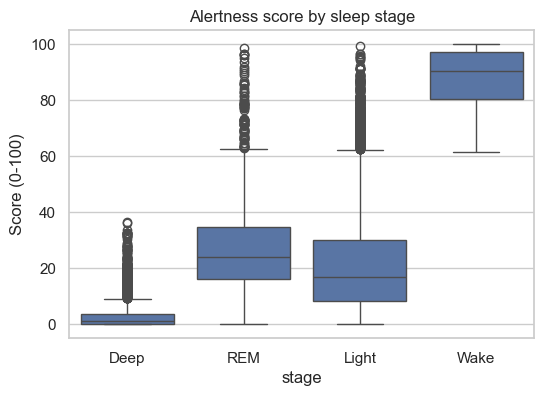

In [9]:

def score_fn(pipe, X):
    return (pipe.predict_proba(X)[:,1]*100).clip(0,100)
epochs_df['score'] = score_fn(best_pipe, epochs_df.drop(columns=['stage','record']))
plt.figure(figsize=(6,4))
sns.boxplot(x='stage', y='score', data=epochs_df, order=['Deep','REM','Light','Wake'])
plt.title('Alertness score by sleep stage')
plt.ylabel('Score (0-100)')
plt.show()


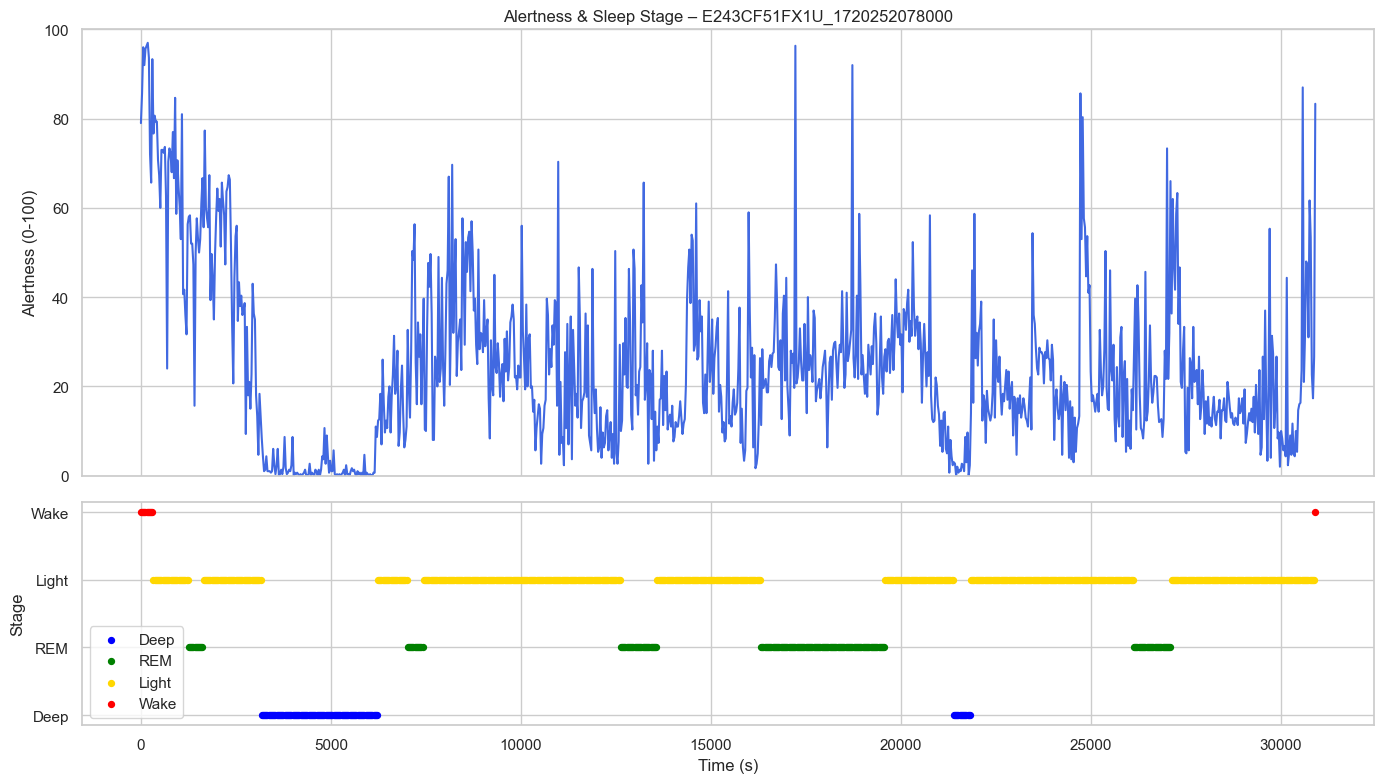

In [10]:

def plot_sample(record_name):
    sample = epochs_df[epochs_df['record']==record_name].copy()
    times = np.arange(len(sample))*EPOCH_SEC
    fig,(ax1,ax2)=plt.subplots(2,1,sharex=True,figsize=(14,8), gridspec_kw={'height_ratios':[2,1]})
    ax1.plot(times, sample['score'], color='royalblue')
    ax1.set_ylabel('Alertness (0-100)')
    ax1.set_title(f'Alertness & Sleep Stage – {record_name}')
    ax1.set_ylim(0,100); ax1.grid(True)
    colors={'Deep':'blue','REM':'green','Light':'gold','Wake':'red'}
    for stage,c in colors.items():
        mask = sample['stage']==stage
        ax2.scatter(times[mask], [stage]*mask.sum(), color=c, label=stage, s=18)
    ax2.set_xlabel('Time (s)'); ax2.set_ylabel('Stage')
    ax2.legend(); ax2.grid(True); plt.tight_layout()
plot_sample(epochs_df['record'].iloc[0])


In [11]:

with open('alertness_model.pkl','wb') as f:
    pickle.dump(best_pipe, f)
print('Saved best model to alertness_model.pkl')


Saved best model to alertness_model.pkl
